# Air Routes

The examples in this notebook demonstrate using the GremlinPython library to connect to and work with a Neptune instance. Using a Jupyter notebook in this way provides a nice way to interact with your Neptune graph database in a familiar and instantly productive environment.

## Load the Air Routes dataset

When the SageMaker notebook instance was created the appropriate Python libraries for working with a Tinkerpop enabled graph were installed. We now need to `import` some classes from those libraries before connecting to our Neptune instance, loading some sample data, and running queries. 

The `neptune.py` helper module that was installed in the _util_ directory does all the necessary heavy lifting with regard to importing classes and loading the air routes dataset. You can reuse this module in your own notebooks, or consult its source code to see how to configure GremlinPython.

In [2]:
!pip install gremlinpython

    100% |████████████████████████████████| 61kB 24.7MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 26.7MB/s ta 0:00:01
    100% |████████████████████████████████| 40kB 24.2MB/s ta 0:00:01
    100% |████████████████████████████████| 491kB 25.8MB/s ta 0:00:01
  Running setup.py bdist_wheel for tornado ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/72/bf/f4/b68fa69596986881b397b18ff2b9af5f8181233aadcc9f76fd
Successfully built tornado
distributed 1.28.1 has requirement tornado>=5, but you'll have tornado 4.5.3 which is incompatible.
  Found existing installation: tornado 5.0.2
    Uninstalling tornado-5.0.2:
      Successfully uninstalled tornado-5.0.2
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
!pip install SPARQLWrapper

    100% |████████████████████████████████| 348kB 26.7MB/s ta 0:00:01
distributed 1.28.1 has requirement tornado>=5, but you'll have tornado 4.5.3 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
!pip install tensorflow==1.14.0

distributed 1.28.1 has requirement tornado>=5, but you'll have tornado 4.5.3 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%run '../util/neptune.py'

Using the neptune module, we can clear any existing data from the database, and load the air routes graph:

In [2]:
neptune.clear()
neptune.bulkLoad('s3://uev-bkt-xj/graph-master/sample-data-trial/', interval=5)

clearing data...
clearing property graph data [edge_batch_size=200, edge_count=Unknown]...
clearing property graph data [vertex_batch_size=200, vertex_count=Unknown]...
clearing rdf data...
done
curl -X POST \
    -H 'Content-Type: application/json' \
    http://neptunedbcluster-yerskextnimt.cluster-celzemcpl3ha.us-east-1.neptune.amazonaws.com:8182/loader -d '{
    "source": "s3://uev-bkt-xj/graph-master/sample-data-trial/",
    "format": "csv",
    "iamRoleArn": "arn:aws:iam::948874832909:role/NeptuneSageMaker-NeptuneBase-NeptuneLoadFromS3Role-F7ZNZZG5KVBV",
    "region": "us-east-1",
    "failOnError": "FALSE"
}'
status_url: http://neptunedbcluster-yerskextnimt.cluster-celzemcpl3ha.us-east-1.neptune.amazonaws.com:8182/loader/8369bd61-5d39-4bc7-b0f3-d203221f6cd3
loading... 0 records inserted
loading... 16004 records inserted
loading... 63402 records inserted
load completed


## Establish access to our Neptune instance

Before we can work with our graph we need to establish a connection to it. This is done using the `DriverRemoteConnection` capability as defined by Apache TinkerPop and supported by GremlinPython. The `neptune.py` helper module facilitates creating this connection.

Once this cell has been run we will be able to use the variable `g` to refer to our graph in Gremlin queries in subsequent cells. By default Neptune uses port 8182 and that is what we connect to below. When you configure your own Neptune instance you can you choose a different endpoint and port number by specifiying the `neptune_endpoint` and `neptune_port` parameters to the `graphTraversal()` method.

In [3]:
g = neptune.graphTraversal()

gremlin: ws://neptunedbcluster-yerskextnimt.cluster-celzemcpl3ha.us-east-1.neptune.amazonaws.com:8182/gremlin


## Let's find out a bit about the graph

Let's start off with a simple query just to make sure our connection to Neptune is working. The queries below look at all of the vertices and edges in the graph and create two maps that show the demographic of the graph. As we are using the air routes data set, not surprisingly, the values returned are related to airports and routes.

In [4]:
vertices = g.V().groupCount().by(T.label).toList()
edges  = g.E().groupCount().by(T.label).toList()
print(vertices)
print(edges)

[{'continent': 7, 'country': 237, 'version': 1, 'airport': 3464}]
[{'contains': 6928, 'route': 50230}]


## Find routes longer than 8,400 miles

The query below finds routes in the graph that are longer than 8,400 miles. This is done by examining the `dist` property of the `routes` edges in the graph. Having found some edges that meet our criteria we sort them in descending order by distance. The `where` step filters out the reverse direction routes for the ones that we have already found beacuse we do not, in this case, want two results for each route. As an experiment, try removing the `where` line and observe the additional results that are returned. Lastly we generate some `path` results using the airport codes and route distances. Notice how we have laid the Gremlin query out over multiple lines to make it easier to read. To avoid errors, when you lay out a query in this way using Python, each line must end with a backslash character "\".

The results from running the query will be placed into the variable `paths`. Notice how we ended the Gremlin query with a call to `toList`. This tells Gremlin that we want our results back in a list. We can then use a Python `for` loop to print those results. Each entry in the list will itself be a list containing the starting airport code, the length of the route and the destination airport code.

In [5]:
paths =  g.V().hasLabel('airport').as_('a') \
              .outE('route').has('dist',gt(8400)) \
              .order().by('dist',Order.decr) \
              .inV() \
              .where(P.lt('a')).by('code') \
              .path().by('code').by('dist').by('code').toList()

for p in paths:
    print(p)

path[SIN, 9523, EWR]
path[DOH, 9025, AKL]
path[PER, 9009, LHR]
path[PTY, 8884, PEK]
path[DXB, 8818, AKL]
path[SIN, 8756, LAX]
path[MEX, 8754, CAN]
path[SYD, 8591, IAH]
path[SYD, 8574, DFW]
path[MNL, 8504, JFK]
path[JNB, 8434, ATL]
path[SIN, 8433, SFO]


## Draw a Bar Chart that represents the routes we just found.

One of the nice things about using Python to work with our graph is that we can take advantage of the larger Python ecosystem of libraries such as `matplotlib`, `numpy` and `pandas` to further analyze our data and represent it pictorially. So, now that we have found some long airline routes we can build a bar chart that represents them graphically.

In [6]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
 
routes = list()
dist = list()

# Construct the x-axis labels by combining the airport pairs we found
# into strings with with a "-" between them. We also build a list containing
# the distance values that will be used to construct and label the bars.
for i in range(len(paths)):
    routes.append(paths[i][0] + '-' + paths[i][2])
    dist.append(paths[i][1])

# Setup everything we need to draw the chart
y_pos = np.arange(len(routes))
y_labels = (0,1000,2000,3000,4000,5000,6000,7000,8000,9000)
freq_series = pd.Series(dist) 
plt.figure(figsize=(11,6))
fs = freq_series.plot(kind='bar')
fs.set_xticks(y_pos, routes)
fs.set_ylabel('Miles')
fs.set_title('Longest routes')
fs.set_yticklabels(y_labels)
fs.set_xticklabels(routes)
fs.yaxis.set_ticks(np.arange(0, 10000, 1000))
fs.yaxis.set_ticklabels(y_labels)

# Annotate each bar with the distance value
for i in range(len(paths)):
    fs.annotate(dist[i],xy=(i,dist[i]+60),xycoords='data',ha='center')

# We are finally ready to draw the bar chart
plt.show()

<Figure size 1100x600 with 1 Axes>

## Explore the distribution of airports by continent

The next example queries the graph to find out how many airports are in each continent. The query starts by finding all vertices that are continents. Next, those vertices are grouped, which creates a map (or dict) whose keys are the continent descriptions and whose values represent the counts of the outgoing edges with a 'contains' label. Finally the resulting map is sorted using the keys in ascending order. That result is then returned to our Python code as the variable `m`. Finally we can print the map nicely using regular Python concepts.

In [7]:
# Return a map where the keys are the continent names and the values are the
# number of airports in that continent.
m = g.V().hasLabel('continent') \
         .group().by('desc').by(__.out('contains').count()) \
         .order(Scope.local).by(Column.keys) \
         .next()

for c,n in m.items():
    print('%4d %s' %(n,c))

 314 Africa
   0 Antarctica
 965 Asia
 598 Europe
 986 North America
 292 Oceania
 309 South America


## Draw a pie chart representing the distribution by continent

Rather than return the results as text like we did above, it might be nicer to display them as percentages on a pie chart. That is what the code in the next cell does. Rather than return the descriptions of the continents (their names) this time our Gremlin query simply retrieves the two digit character code representing each continent.

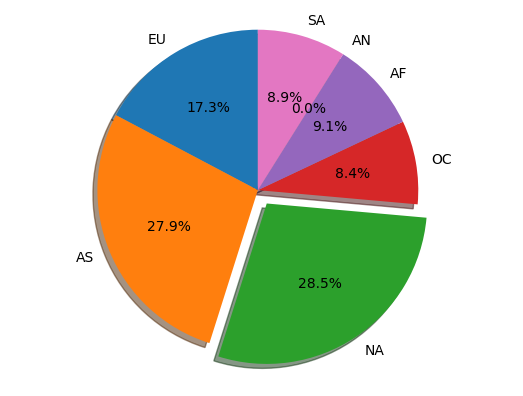

In [8]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

# Return a map where the keys are the continent codes and the values are the
# number of airports in that continent.
m = g.V().hasLabel('continent').group().by('code').by(__.out().count()).next()

fig,pie1 = plt.subplots()

pie1.pie(m.values() \
        ,labels=m.keys() \
        ,autopct='%1.1f%%'\
        ,shadow=True \
        ,startangle=90 \
        ,explode=(0,0,0.1,0,0,0,0))

pie1.axis('equal')  

plt.show()

## Find some routes from London to San Jose and draw them

One of the nice things about connected graph data is that it lends itself nicely to visualization that people can get value from looking at. The Python `networkx` library makes it fairly easy to draw a graph. The next example takes advantage of this capability to draw a directed graph (DiGraph) of a few airline routes.

The query below starts by finding the vertex that represents London Heathrow (LHR). It then finds 15 routes from LHR that end up in San Jose California (SJC) with one stop on the way. Those routes are returned as a list of paths. Each path will contain the three character IATA codes representing the airports found.

The main purpose of this example is to show that we can easily extract part of a larger graph and render it graphically in a way that is easy for an end user to comprehend.

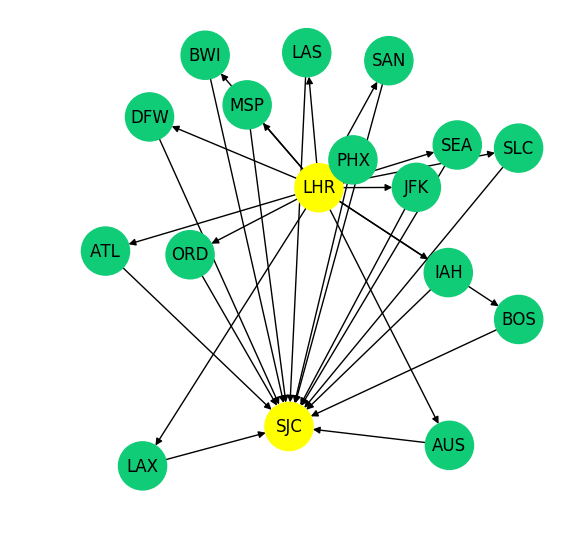

In [9]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

# Find up to 15 routes from LHR to SJC that make one stop.
             # \
paths = g.V().has('airport','code','LHR') \
             .out().out().has('code','SJC').limit(15) \
             .path().by('code').toList()

# Create a new empty DiGraph
G=nx.DiGraph()

# Add the routes we found to DiGraph we just created
for p in paths:
    G.add_edge(p[0],p[1])
    G.add_edge(p[1],p[2])

# Give the starting and ending airports a different color
colors = []

for label in G:
    if label in['LHR','SJC']:
        colors.append('yellow')
    else:
        colors.append('#11cc77')

# Now draw the graph    
plt.figure(figsize=(5,5))
nx.draw(G, node_color=colors, node_size=1200, with_labels=True)
plt.show()

# PART 2 - Examples that use iPython Gremlin

This part of the notebook contains examples that use the iPython Gremlin Jupyter extension to work with a Neptune instance using Gremlin.

## Configuring iPython Gremlin to work with Neptune

Before we can start to use iPython Gremlin we need to load the Jupyter Kernel extension and configure access to our Neptune endpoint.

In [12]:
!python -c "import py2neo; print py2neo.__version__"

  File "<string>", line 1
    import py2neo; print py2neo.__version__
                              ^
SyntaxError: invalid syntax


In [13]:
!pip install py2neo==2.0

    100% |████████████████████████████████| 256kB 27.6MB/s ta 0:00:01
  Running setup.py bdist_wheel for py2neo ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c8/c2/d7/bf9c1d0920f010d3f4535e642466b5d145b88cf0d53060977c
Successfully built py2neo
distributed 1.28.1 has requirement tornado>=5, but you'll have tornado 4.5.3 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
# Create a string containing the full Web Socket path to the endpoint
# Replace <neptune-instance-name> with the name of your Neptune instance.
# which will be of the form myinstance.us-east-1.neptune.amazonaws.com

#neptune_endpoint = '<neptune-instance-name>'
neptune_endpoint = os.environ['NEPTUNE_CLUSTER_ENDPOINT']
neptune_port = os.environ['NEPTUNE_CLUSTER_PORT']
neptune_gremlin_endpoint = 'ws://' + neptune_endpoint + ':' + neptune_port + '/gremlin'

# Load the iPython Gremlin extension and setup access to Neptune.
%load_ext gremlin
%gremlin.connection.set_current $neptune_gremlin_endpoint

ModuleNotFoundError: No module named 'gremlin'

## Run this cell if you need to reload the Gremlin extension.
Occaisionally it becomes necessary to reload the iPython Gremlin extension to make things work. Running this cell will do that for you.

In [ ]:
# Re-load the iPython Gremlin Jupyter Kernel extension.
%reload_ext gremlin

## A simple query to make sure we can connect to the graph. 

Find all the airports in England that are in London. Notice that when using iPython Gremlin you do not need to use a terminal step such as `next` or `toList` at the end of the query in order to get it to return results. As mentioned earlier in this post, the `%reset -f` is to work around a known issue with iPython Gremlin.

In [ ]:
%reset -f
%gremlin g.V().has('airport','region','GB-ENG') \
              .has('city','London').values('desc')

### You can store the results of a query in a variable just as when using Gremlin Python.
The query below is the same as the previous one except that the results of running the query are stored in the variable 'places'. We can then work with that variable in our code.

In [ ]:
%reset -f
places = %gremlin g.V().has('airport','region','GB-ENG') \
                       .has('city','London').values('desc')
for p in places:
    print(p)

### Treating entire cells as Gremlin
Any cell that begins with `%%gremlin` tells iPython Gremlin to treat the entire cell as Gremlin. You cannot mix Python code into these cells.

In [ ]:
%%gremlin
g.V().has('city','London').has('region','GB-ENG').count()
